#DATASCI W261, Machine Learning at Scale
--------
####Assignement:  week \#2
####Lei Yang (leiyang@berkeley.edu)
####Due: 2016-01-26, 8AM PST

###*HW2.0.*
- What is a race condition in the context of parallel computation? Give an example.
- What is MapReduce?
- How does it differ from Hadoop?
- Which programming paradigm is Hadoop based on? Explain and give a simple example in code and show the code running.


####<span style="color:red">HW2.0 Answer:</span>
- A race condition refers to the scenario where the output is dependent on the sequence or timing of other uncontrollable events [[ref](https://en.wikipedia.org/wiki/Race_condition)]. For example, when a few paralle threads have interaction with some common object, due to the lack of coordination and synchronization, the execution can cause invalid state of the object, which can randomly affect the result of each thread. For example, if a word counting parallel job needs to update the total count frequently, the count variable must be locked during the update; otherwise a thread can read the count while other threads are updating it, and the final accumulation will be less the true value.
- MapReduce is a programming model for processing large data sets with a parallel, distributed algorithm on a cluster [[ref](https://en.wikipedia.org/wiki/MapReduce)]. It has two phases:
 - Map(): performs filtering and sorting
 - Reduce(): performs a summary operation
- Hadoop [[ref](https://hadoop.apache.org)] is an open source project which provides an implementation of the MapReduce functionality. It has two components:
 - HDFS: Hadoop distributed file system
 - MapReduce implementation
- Hadoop is based on Functional Programing languages [[ref](https://en.wikipedia.org/wiki/Functional_programming)].
 - A key feature of functional languages is the concept of higher-order functions, or functions that can accept other functions as arguments.
 - Map and reduce are higher-order functions
 - all about the evaluation of mathematical functions and avoids changing state and mutable data.
 - It is a declarative programming paradigm, which means programming is done with expressions.
 - In functional code, the output value of a function depends only on the arguments that are input to the function, so calling a function f twice with the same value for an argument x will produce the same result f(x) each time.
 - Example is given below:

In [3]:
# an embarassingly simple example of Functional Programing

# function to count character in a word
def char_count(word):
    return len(word)

# apply the function on a sentence
sentence = 'this is a testing sentence to show how char_count function works on each word'
print 'Count character in each word of sentence: '
print {word:char_count(word) for word in sentence.split()}

count character in each word of sentence: 
{'a': 1, 'function': 8, 'on': 2, 'word': 4, 'sentence': 8, 'this': 4, 'is': 2, 'testing': 7, 'to': 2, 'how': 3, 'each': 4, 'show': 4, 'works': 5, 'char_count': 10}


###start yarn and hdfs

In [99]:
!/usr/local/Cellar/hadoop/2*/sbin/start-yarn.sh
!/usr/local/Cellar/hadoop/2*/sbin/start-dfs.sh

starting yarn daemons
starting resourcemanager, logging to /usr/local/Cellar/hadoop/2.7.1/libexec/logs/yarn-leiyang-resourcemanager-Leis-MacBook-Pro.local.out
localhost: starting nodemanager, logging to /usr/local/Cellar/hadoop/2.7.1/libexec/logs/yarn-leiyang-nodemanager-Leis-MacBook-Pro.local.out
Starting namenodes on [localhost]
localhost: starting namenode, logging to /usr/local/Cellar/hadoop/2.7.1/libexec/logs/hadoop-leiyang-namenode-Leis-MacBook-Pro.local.out
localhost: starting datanode, logging to /usr/local/Cellar/hadoop/2.7.1/libexec/logs/hadoop-leiyang-datanode-Leis-MacBook-Pro.local.out
Starting secondary namenodes [0.0.0.0]
0.0.0.0: starting secondarynamenode, logging to /usr/local/Cellar/hadoop/2.7.1/libexec/logs/hadoop-leiyang-secondarynamenode-Leis-MacBook-Pro.local.out


###create a folder and upload enronemail_1h.txt to hdfs

In [25]:
!hdfs dfs -mkdir -p /user/lei
!hdfs dfs -put enronemail_1h.txt /user/lei

16/01/23 10:56:17 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/01/23 10:56:19 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


###*HW2.1.* Sort in Hadoop MapReduce
- Given as input: Records of the form < integer, “NA”>, where integer is any integer, and “NA” is just the empty string.
- Output: sorted key value pairs of the form < integer, “NA”> in decreasing order; what happens if you have multiple reducers? Do you need additional steps? Explain.
- Write code to generate N  random records of the form < integer, “NA”>. Let N = 10,000.
- Write the python Hadoop streaming map-reduce job to perform this sort. Display the top 10 biggest numbers. Display the 10 smallest numbers

###<span style="color:red">HW2.1 Answer:</span>


###Simulate 10,000 records of < integer, "NA">

In [4]:
# clean up HDFS
!hdfs dfs -rm HW2_1.txt
import random
text_file = open("HW2_1.txt", "w")
N = 10000
# simulate and write the records
for i in range(N):
    text_file.writelines('<%d, "NA">\n' %(random.randint(1, N)))
text_file.close()
# upload the records to HDFS
!hdfs dfs -put HW2_1.txt /user/leiyang

16/01/23 19:07:51 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/01/23 19:07:51 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted HW2_1.txt
16/01/23 19:07:52 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


###Mapper
- as the shuffler will do the sorting, mapper just need to emit word with integer as the key

In [100]:
%%writefile mapper.py
#!/usr/bin/python
import sys
for line in sys.stdin:  
    # extract the integer component
    parts = line.strip('<').split(',')
    # skip bad records
    if len(parts) == 0:
        continue
    # verify numeric format
    try:
        key = int(parts[0])
    except ValueError:
        continue
    
    # use integer as the key, and the entire record is value emitted by the mapper
    print "%d\t%s" %(key, line.strip())

Overwriting mapper.py


###Reducer

In [101]:
%%writefile reducer.py
#!/usr/bin/python
import sys, Queue

n_max, n_min = 10, 10
q_max = Queue.Queue(n_max)
a_min = []

for line in sys.stdin:
    rec = line.split('\t')[1].strip()
    # put the biggest
    if len(a_min) < n_min:
        a_min.append(rec)
    
    # whatever left is the smallest
    if q_max.full():
        q_max.get()
    q_max.put(rec)

print '\n%d smallest records:' %n_min
for record in a_min:
    print record

print '\n%d biggest records:' %n_max
for i in range(n_max):
    print q_max.get()


Overwriting reducer.py


###Run the job with Hadoop Streaming
- add parameter *-D mapred.text.key.comparator.options=-n* to sort the key by numerical format
- **Note:** Hadoop log is suppressed to only show error in all job executions of this HW, to be viewer friendly
 - added to the hadoop-env.sh file: *export HADOOP_ROOT_LOGGER=WARN,DRFA*

In [103]:
!hdfs dfs -rm -r results
!hadoop jar /usr/local/Cellar/hadoop/2.*/libexec/share/hadoop/tools/lib/hadoop-streaming-2*.jar -D mapred.text.key.comparator.options=-n -mapper mapper.py -reducer reducer.py -input HW2_1.txt -output results

Deleted results


###Check 10 smallest and biggest

In [104]:
!hdfs dfs -cat results/part-00000

	
10 smallest records:	
<1, "NA">	
<100, "NA">	
<1000, "NA">	
<1000, "NA">	
<1002, "NA">	
<1004, "NA">	
<1005, "NA">	
<1005, "NA">	
<1006, "NA">	
<1006, "NA">	
	
10 smallest records:	
<9991, "NA">	
<9993, "NA">	
<9994, "NA">	
<9994, "NA">	
<9994, "NA">	
<9996, "NA">	
<9996, "NA">	
<9999, "NA">	
<9999, "NA">	
<9999, "NA">	


###*HW2.2.*  WORDCOUNT
- Using the Enron data from HW1 and Hadoop MapReduce streaming, write the mapper/reducer job that  will determine the word count (number of occurrences) of each white-space delimitted token (assume spaces, fullstops, comma as delimiters). 
- Examine the word “assistance” and report its word count results.
- CROSSCHECK: >grep assistance enronemail_1h.txt|cut -d$'\t' -f4| grep assistance|wc -l    
  - 8    
  - \#NOTE  "assistance" occurs on 8 lines but how many times does the token occur? 10 times! This is the number we are looking for!

###Mapper

In [105]:
%%writefile mapper.py
#!/usr/bin/python
import sys, re, string
# define regex for punctuation removal
regex = re.compile('[%s]' % re.escape(string.punctuation))
# input comes from STDIN (standard input)
for line in sys.stdin:
    # use subject and body
    line = line.split('\t', 2)[-1]
    # remove punctuations, only have white-space as delimiter
    line = regex.sub(' ', line.lower())
    # split the line into words
    words = line.split()
    # increase counters
    for word in words:
        # write the results to STDOUT (standard output);
        # what we output here will be the input for the
        # Reduce step, i.e. the input for reducer.py
        #
        # tab-delimited; the trivial word count is 1
        print '%s\t%s' % (word, 1)

Overwriting mapper.py


###Reducer

In [106]:
%%writefile reducer.py
#!/usr/bin/python
from operator import itemgetter
import sys

current_word = None
current_count = 0
word = None
wordcount = {}

# input comes from STDIN
for line in sys.stdin:
    # remove leading and trailing whitespace
    line = line.strip()

    # parse the input we got from mapper.py
    word, count = line.split('\t', 1)

    # convert count (currently a string) to int
    try:
        count = int(count)
    except ValueError:
        # count was not a number, so silently
        # ignore/discard this line
        continue

    # this IF-switch only works because Hadoop sorts map output
    # by key (here: word) before it is passed to the reducer
    if current_word == word:
        current_count += count
    else:
        if current_word:
            # save count            
            wordcount[current_word] = current_count
        current_count = count
        current_word = word

# do not forget to save the last word count if needed!
if current_word == word:    
    wordcount[current_word] = current_count
    
# found count for word assistance
findword = 'assistance'
print '%s\t%d' %(findword, wordcount[findword] if findword in wordcount else 0)

Overwriting reducer.py


###Run the job with Hadoop streaming

In [107]:
!hdfs dfs -rm -r results
!hadoop jar /usr/local/Cellar/hadoop/2.*/libexec/share/hadoop/tools/lib/hadoop-streaming-2.7.1.jar -mapper mapper.py -reducer reducer.py -input /user/lei/enronemail_1h.txt -output results

Deleted results


###<span style="color:red">HW2.2 Results:</span>

In [108]:
!hdfs dfs -cat results/part-00000

assistance	10


###*HW2.2.1*  Using Hadoop MapReduce and your wordcount job (from HW2.2) determine the top-10 occurring tokens (most frequent tokens)

###Reducer 
- same as above, only sort total count at the end
- *realistically*, for big data, there should be a second job to just sort the count

In [109]:
%%writefile reducer.py
#!/usr/bin/python
from operator import itemgetter
import sys, operator

current_word = None
current_count = 0
word = None
wordcount = {}

# input comes from STDIN
for line in sys.stdin:
    # remove leading and trailing whitespace
    line = line.strip()

    # parse the input we got from mapper.py
    word, count = line.split('\t', 1)

    # convert count (currently a string) to int
    try:
        count = int(count)
    except ValueError:
        # count was not a number, so silently
        # ignore/discard this line
        continue

    # this IF-switch only works because Hadoop sorts map output
    # by key (here: word) before it is passed to the reducer
    if current_word == word:
        current_count += count
    else:
        if current_word:
            # save count            
            wordcount[current_word] = current_count
        current_count = count
        current_word = word

# do not forget to save the last word count if needed!
if current_word == word:    
    wordcount[current_word] = current_count
    
# sort count top get top n counts:
n = 10
sort_count = sorted(wordcount.items(), key=operator.itemgetter(1))
print 'Top %d counts out of %d words:' %(n, len(sort_count))
for i in range(n):
    print '%s\t%d' %(sort_count[-i-1])

Overwriting reducer.py


###Run the job with Hadoop streaming

In [110]:
!hdfs dfs -rm -r results
!hadoop jar /usr/local/Cellar/hadoop/2.*/libexec/share/hadoop/tools/lib/hadoop-streaming-2.7.1.jar -mapper mapper.py -reducer reducer.py -input /user/lei/enronemail_1h.txt -output results

Deleted results


###<span style="color:red">HW2.2.1 Results:</span>

In [111]:
!hdfs dfs -cat results/part-00000

Top 10 counts out of 5408 words:	
the	1247
to	964
and	670
of	566
a	543
you	445
in	418
your	395
ect	382
for	374


###*HW2.3.* Multinomial NAIVE BAYES with NO Smoothing
- Using the Enron data from HW1 and Hadoop MapReduce, write  a mapper/reducer job(s) that will both learn  Naive Bayes classifier and classify the Enron email messages using the learnt Naive Bayes classifier. 
- Use all white-space delimitted tokens as independent input variables (assume spaces, fullstops, commas as delimiters). 
- Note: for multinomial Naive Bayes, the Pr(X=“assistance”|Y=SPAM) is calculated as follows:
 - the number of times “assistance” occurs in SPAM labeled documents / the number of words in documents labeled SPAM 
 - E.g.,   “assistance” occurs 5 times in all of the documents Labeled SPAM, and the length in terms of the number of words in all documents labeled as SPAM (when concatenated) is 1,000. Then Pr(X=“assistance”|Y=SPAM) = 5/1000. 
 - Note this is a multinomial estimation of the class conditional for a Naive Bayes Classifier. No smoothing is needed in this HW. 
 - Multiplying lots of probabilities, which are between 0 and 1, can result in floating-point underflow. Since log(xy) = log(x) + log(y), it is better to perform all computations by summing logs of probabilities rather than multiplying probabilities. 
 - Please pay attention to probabilites that are zero! They will need special attention. Count up how many times you need to process a zero probabilty for each class and report. 
- Report the performance of your learnt classifier in terms of misclassifcation error rate of your multinomial Naive Bayes Classifier. 
- Plot a histogram of the posterior probabilities (i.e., Pr(Class|Doc)) for each class over the training set. Summarize what you see. 
- Error Rate = misclassification rate with respect to a provided set (say training set in this case). It is more formally defined here:
 - Let DF represent the evalution set in the following:
 - Err(Model, DF) = |{(X, c(X)) ∈ DF : c(X) != Model(x)}|   / |DF|
 - Where || denotes set cardinality; c(X) denotes the class of the tuple X in DF; and Model(X) denotes the class inferred by the Model “Model”

   

###Mapper (training)
- Differ from previous one, in that we need to separate counts for spam and ham
- key~value pair: word~[1, flag for ham/spam]

In [112]:
%%writefile mapper_t.py
#!/usr/bin/python
import sys, re, string
# define regex for punctuation removal
regex = re.compile('[%s]' % re.escape(string.punctuation))
# input comes from STDIN (standard input)
for line in sys.stdin:
    # use subject and body
    msg = line.split('\t', 2)
    if len(msg) < 3:
        continue
    msgID, isSpam = msg[0], msg[1]
    
    # remove punctuations, only have white-space as delimiter
    words = regex.sub(' ', msg[-1].lower())
    # split the line into words
    words = words.split()
    # increase counters
    for word in words:
        # write the results to STDOUT (standard output);
        # what we output here will be the input for the
        # Reduce step, i.e. the input for reducer.py
        #
        # tab-delimited; the trivial word count is 1
        print '%s\t%d\t%s\t%s' % (word, 1, isSpam, msgID)

Overwriting mapper_t.py


###Reducer (training)
Assuming *positional independence*, and without smoothing, the multinomial NB conditional probability $P(t | c)$ can be estimated as:
$$
\hat{P}(t\mid c)=\frac{T_{ct}+0}{(\sum_{t^\prime \in V}{T_{ct^\prime}})+B},
$$

where $B=|V|$ is the number of terms in the vocabulary $V$ (including all text classes), and $T_{ct}$ is the count of word *t* in class *c*. 

In [113]:
%%writefile reducer_t.py
#!/usr/bin/python
from operator import itemgetter
import sys, operator
import numpy as np

current_word = None
smooth_factor = 0 # no smoothing
current_count = [smooth_factor, smooth_factor]
msgIDs = {}
word = None
wordcount = {}

# input comes from STDIN
for line in sys.stdin:
    # remove leading and trailing whitespace
    line = line.strip()

    # parse the input we got from mapper.py
    word, count, isSpam, msgID = line.split('\t', 3)

    # convert count and spam flag (currently a string) to int
    try:
        count = int(count)
        isSpam = int(isSpam)
    except ValueError:
        # count was not a number, so silently
        # ignore/discard this line
        continue
    
    # handle msgID - store all IDs as we don't have too much
    # not the best way to get prior, a two-level MapReduce jobs (ID - word) would be optimal
    if msgID not in msgIDs:
        msgIDs[msgID] = isSpam

    # this IF-switch only works because Hadoop sorts map output
    # by key (here: word) before it is passed to the reducer
    if current_word == word:        
        current_count[isSpam] += count
    else:
        if current_word:
            # count finish for one word, save it
            wordcount[current_word] = current_count
        # initialize new count for new word
        current_count = [smooth_factor, smooth_factor]
        current_count[isSpam] = count                
        current_word = word

# do not forget to save the last word count if needed!
if current_word == word:    
    wordcount[current_word] = current_count
    
# calculate NB parameters, and write the dictionary to a file for the classification job
# prior probabilities
n_msg = len(msgIDs)
n_spam = sum(msgIDs.values())
n_ham = n_msg - n_spam
print '%s\t%s\t%s' %('prior_prob', 1.0*n_ham/n_msg, 1.0*n_spam/n_msg)

# conditional probability
n_total = np.sum(wordcount.values(), 0)
for (key,value) in zip(wordcount.keys(), wordcount.values()/(1.0*n_total)):
    print '%s\t%s\t%s' %(key, value[0], value[1])

Overwriting reducer_t.py


###Mapper (classification)
- key~value pair: msgID~[probability, flag]

In [114]:
%%writefile mapper_c.py
#!/usr/bin/python
import sys, re, string, subprocess
# read the probability from HDFS
prob = {}
cat = subprocess.Popen(["hadoop", "fs", "-cat", "prob/part-00000"], stdout=subprocess.PIPE)
for line in cat.stdout:    
    word, p0, p1 = line.split()
    prob[word] = [p0, p1]

# get prior probability
prior = prob['prior_prob']

# define regex for punctuation removal
regex = re.compile('[%s]' % re.escape(string.punctuation))
# input comes from STDIN (standard input)
for line in sys.stdin:
    # use subject and body
    msg = line.split('\t', 2)
    # skip bad message 
    if len(msg) < 3:
        continue
    msgID, isSpam = msg[0], msg[1]    
    # remove punctuations, only have white-space as delimiter
    words = regex.sub(' ', msg[-1].lower())
    # split the line into words
    words = words.split()
    # increase counters
    for word in words:
        # write the results to STDOUT (standard output);
        # what we output here will be the input for the
        # Reduce step, i.e. the input for reducer.py
        #
        # tab-delimited; the trivial word count is 1                
        print '%s\t%s\t%s\t%s\t%s\t%s' % (msgID, prob[word][0], prob[word][1], isSpam, prior[0], prior[1])

Overwriting mapper_c.py


###Reducer (classification)
To classify a message, the posterior probability of class $c$ can be calculated as:
$$
c_{map}=\arg\max_{c\in\mathbb C}[\log{\hat{P}(c)}+\sum_{1\leqslant k \leqslant n_d}{\log{\hat{P}(t_k\mid c)}}],
$$
where $\hat{P}(t_k\mid c)$ is estimated above with *positional independence* assumption as $\hat{P}(t\mid c)$.

In [115]:
%%writefile reducer_c.py
#!/usr/bin/python
from operator import itemgetter
import sys, operator, math
import numpy as np

current_msg = None
current_prob = [0, 0] 
current_truth = 0
msgID = None
n_error = 0
n_msg = 0
n_zero = [0, 0]

print '%s\t%s\t%s' %('TRUTH', 'PREDICTION', 'EMAIL ID')
# input comes from STDIN
for line in sys.stdin:
    #print line
    # remove leading and trailing whitespace
    line = line.strip()

    # parse the input we got from mapper_c.py
    msgID, p0, p1, isSpam, pr0, pr1 = line.split('\t')
    prob = [float(p0), float(p1)]
    
    # convert count and spam flag (currently a string) to int
    try:        
        isSpam = int(isSpam)
    except ValueError:
        # count was not a number, so silently
        # ignore/discard this line
        continue
    
    # this IF-switch only works because Hadoop sorts map output
    # by key (here: word) before it is passed to the reducer
    if current_msg == msgID:        
        current_prob = np.sum([[math.log(x) if x>0 else float('-inf') for x in prob], current_prob], 0)
    else:
        if current_msg:
            # count finish for current word, predict and print result
            pred = np.argmax(current_prob)
            n_error += pred != current_truth
            n_msg += 1
            n_zero[current_truth] += float('-inf') in current_prob
            print '%s\t%s\t%s' %(current_truth, pred, current_msg)
                    
        # initialize new count for new word
        prior = [math.log(float(pr0)), math.log(float(pr1))]
        current_prob = np.sum([[math.log(x) if x>0 else float('-inf') for x in prob], prior], 0)
        current_msg = msgID
        current_truth = isSpam

# do not forget to print the last msg result if needed!
if current_msg == msgID:
    pred = np.argmax(current_prob)
    n_error += pred != isSpam
    n_msg += 1
    n_zero[current_truth] += float('-inf') in current_prob
    print '%s\t%s\t%s' %(current_truth, pred, msgID)
    
# calculate the overall error rate
print 'Error rate: %.4f' %(1.0*n_error/n_msg)
print 'Number of messages with zero probability: spam(%d), ham(%d)' %(n_zero[1], n_zero[0])

Overwriting reducer_c.py


###Run the jobs with Hadoop Streaming

In [116]:
# clean up HDFS
!hdfs dfs -rm -r results
!hdfs dfs -rm -r prob
# run training job
!hadoop jar /usr/local/Cellar/hadoop/2.*/libexec/share/hadoop/tools/lib/hadoop-streaming-2.7.1.jar -mapper mapper_t.py -reducer reducer_t.py -input /user/lei/enronemail_1h.txt -output prob
# run classification job
!hadoop jar /usr/local/Cellar/hadoop/2.*/libexec/share/hadoop/tools/lib/hadoop-streaming-2.7.1.jar -mapper mapper_c.py -reducer reducer_c.py -input /user/lei/enronemail_1h.txt -output results

Deleted results
Deleted prob


###<span style="color:red">HW2.3 Results: </span>

In [117]:
!hdfs dfs -cat results/part-00000

TRUTH	PREDICTION	EMAIL ID
0	0	0001.1999-12-10.farmer
0	0	0001.1999-12-10.kaminski
0	0	0001.2000-01-17.beck
0	0	0001.2000-06-06.lokay
0	0	0001.2001-02-07.kitchen
0	0	0001.2001-04-02.williams
0	0	0002.1999-12-13.farmer
0	0	0002.2001-02-07.kitchen
1	1	0002.2001-05-25.SA_and_HP
1	1	0002.2003-12-18.GP
1	1	0002.2004-08-01.BG
0	0	0003.1999-12-10.kaminski
0	0	0003.1999-12-14.farmer
0	0	0003.2000-01-17.beck
0	0	0003.2001-02-08.kitchen
1	1	0003.2003-12-18.GP
1	1	0003.2004-08-01.BG
0	0	0004.1999-12-10.kaminski
0	0	0004.1999-12-14.farmer
0	0	0004.2001-04-02.williams
1	1	0004.2001-06-12.SA_and_HP
1	1	0004.2004-08-01.BG
0	0	0005.1999-12-12.kaminski
0	0	0005.1999-12-14.farmer
0	0	0005.2000-06-06.lokay
0	0	0005.2001-02-08.kitchen
1	1	0005.2001-06-23.SA_and_HP
1	1	0005.2003-12-18.GP
0	0	0006.1999-12-13.kaminski
0	0	0006.2001-02-08.kitchen
0	0	0006.2001-04-03.williams
1	1	0006.2001-06-25.SA_and_HP
1	1	0006.2003-12-18.GP
1	1	0006.2004-08-01.BG
0	0	0007.1999-12-13.kaminski
0	0	0007.1999-12-14.farmer
0	0	0

###Discussion on posterior probability:
- the NB posterior probability is: 
$$
P(Y=y_k\mid X_1,X_2, ...,X_n)=\frac{P(Y=y_k)\prod_i{P(X_i\mid Y=y_k)}}{\sum_j{P(Y=y_j)\prod_i{P(X_i\mid Y=y_j)}}}
$$
- from the results we can see for each message, there are words that only belong to one category
 - in this case the conditional probability of those words for the opposite category, $P(X_i\mid Y=y_j)$, are zero   
 - and this will make one term (with respect to $j$) on the denominator become zero, 
 - and thus the posterior probability is 1 for the category that contains all the words from the email, and 0 for the other category (hisogram below)
- this fact illustrates that NB classifier is *over-confident*, the training error in this case is small, but the validation error can be big
- and this brings the need for smoothing, such that the posterior probability of one class won't be 1

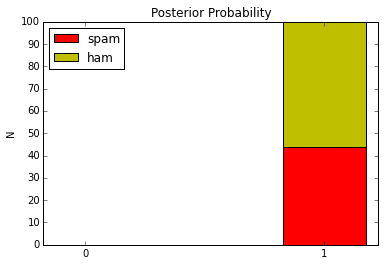

In [8]:
# plot histogram for posterio probability
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

N = 2
# 44 spam and 56 ham all has posterior probability of 1
spam = (0, 44)
ham = (0, 56)
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, spam, width, color='r')
p2 = plt.bar(ind, ham, width, color='y',bottom=spam,)

plt.ylabel('N')
plt.title('Posterior Probability')
plt.xticks(ind + width/2., ('0', '1'))
plt.yticks(np.arange(0, 110, 10))
plt.legend((p1[0], p2[0]), ('spam', 'ham'), loc=2)

plt.show()

###*HW2.4* Repeat HW2.3 with the following modification: 
- use Laplace plus-one smoothing,
- compare the misclassifcation error rates for 2.3 versus 2.4 and explain the differences.
- **we only need to change the reducer in training step, the rest remains the same as previous**

###Reducer (training)
- minor change: assign 1 to the smooth_factor (instead of 0 in HW2.3)

In [118]:
%%writefile reducer_t.py
#!/usr/bin/python
from operator import itemgetter
import sys, operator
import numpy as np

current_word = None
smooth_factor = 1 # no smoothing
current_count = [smooth_factor, smooth_factor]
msgIDs = {}
word = None
wordcount = {}

# input comes from STDIN
for line in sys.stdin:
    # remove leading and trailing whitespace
    line = line.strip()

    # parse the input we got from mapper.py
    word, count, isSpam, msgID = line.split('\t', 3)

    # convert count and spam flag (currently a string) to int
    try:
        count = int(count)
        isSpam = int(isSpam)
    except ValueError:
        # count was not a number, so silently
        # ignore/discard this line
        continue
    
    # handle msgID - store all IDs as we don't have too much
    # not the best way to get prior, a two-level MapReduce jobs (ID - word) would be optimal
    if msgID not in msgIDs:
        msgIDs[msgID] = isSpam

    # this IF-switch only works because Hadoop sorts map output
    # by key (here: word) before it is passed to the reducer
    if current_word == word:        
        current_count[isSpam] += count
    else:
        if current_word:
            # count finish for one word, save it
            wordcount[current_word] = current_count
        # initialize new count for new word
        current_count = [smooth_factor, smooth_factor]
        current_count[isSpam] = count                
        current_word = word

# do not forget to save the last word count if needed!
if current_word == word:    
    wordcount[current_word] = current_count
    
# calculate NB parameters, and write the dictionary to a file for the classification job
# prior probabilities
n_msg = len(msgIDs)
n_spam = sum(msgIDs.values())
n_ham = n_msg - n_spam
print '%s\t%s\t%s' %('prior_prob', 1.0*n_ham/n_msg, 1.0*n_spam/n_msg)

# conditional probability
n_total = np.sum(wordcount.values(), 0)
for (key,value) in zip(wordcount.keys(), wordcount.values()/(1.0*n_total)):
    print '%s\t%s\t%s' %(key, value[0], value[1])

Overwriting reducer_t.py


###Run the jobs with Hadoop Streaming

In [119]:
# clean up HDFS
!hdfs dfs -rm -r results
!hdfs dfs -rm -r prob
# run training job
!hadoop jar /usr/local/Cellar/hadoop/2*/libexec/share/hadoop/tools/lib/hadoop-streaming-2*.jar -mapper mapper_t.py -reducer reducer_t.py -input /user/lei/enronemail_1h.txt -output prob
# run classification job
!hadoop jar /usr/local/Cellar/hadoop/2*/libexec/share/hadoop/tools/lib/hadoop-streaming-2*.jar -mapper mapper_c.py -reducer reducer_c.py -input /user/lei/enronemail_1h.txt -output results

Deleted results
Deleted prob


###<span style="color:red">HW2.4 Results: </span>

In [120]:
!hdfs dfs -cat results/part-00000

TRUTH	PREDICTION	EMAIL ID
0	0	0001.1999-12-10.farmer
0	0	0001.1999-12-10.kaminski
0	0	0001.2000-01-17.beck
0	0	0001.2000-06-06.lokay
0	0	0001.2001-02-07.kitchen
0	0	0001.2001-04-02.williams
0	0	0002.1999-12-13.farmer
0	0	0002.2001-02-07.kitchen
1	1	0002.2001-05-25.SA_and_HP
1	1	0002.2003-12-18.GP
1	1	0002.2004-08-01.BG
0	0	0003.1999-12-10.kaminski
0	0	0003.1999-12-14.farmer
0	0	0003.2000-01-17.beck
0	0	0003.2001-02-08.kitchen
1	1	0003.2003-12-18.GP
1	1	0003.2004-08-01.BG
0	0	0004.1999-12-10.kaminski
0	0	0004.1999-12-14.farmer
0	0	0004.2001-04-02.williams
1	1	0004.2001-06-12.SA_and_HP
1	1	0004.2004-08-01.BG
0	0	0005.1999-12-12.kaminski
0	0	0005.1999-12-14.farmer
0	0	0005.2000-06-06.lokay
0	0	0005.2001-02-08.kitchen
1	1	0005.2001-06-23.SA_and_HP
1	1	0005.2003-12-18.GP
0	0	0006.1999-12-13.kaminski
0	0	0006.2001-02-08.kitchen
0	0	0006.2001-04-03.williams
1	1	0006.2001-06-25.SA_and_HP
1	1	0006.2003-12-18.GP
1	1	0006.2004-08-01.BG
0	0	0007.1999-12-13.kaminski
0	0	0007.1999-12-14.farmer
0	0	0

###HW2.4 Discussion:
- smoothing essentially add noise to the data
- and thus introduce some misclassification on the training set
- but it can have better results on validation data

###*HW2.5.* Repeat HW2.4. 
- This time when modeling and classification ignore tokens with a frequency of less than three (3) in the training set. 
- How does it affect the misclassifcation error of learnt naive multinomial Bayesian Classifier on the training dataset:
- **we only need to change the reducer in training step and the mapper for classification, the rest remains the same as previous**

###Reducer (training)
- minor change with previous: at the end not emitting word~probability pair with less than 3 word count

In [121]:
%%writefile reducer_t.py
#!/usr/bin/python
from operator import itemgetter
import sys, operator
import numpy as np

current_word = None
smooth_factor = 0 # no smoothing
current_count = [smooth_factor, smooth_factor]
msgIDs = {}
word = None
wordcount = {}

# input comes from STDIN
for line in sys.stdin:
    # remove leading and trailing whitespace
    line = line.strip()

    # parse the input we got from mapper.py
    word, count, isSpam, msgID = line.split('\t', 3)

    # convert count and spam flag (currently a string) to int
    try:
        count = int(count)
        isSpam = int(isSpam)
    except ValueError:
        # count was not a number, so silently
        # ignore/discard this line
        continue
    
    # handle msgID - store all IDs as we don't have too much
    # not the best way to get prior, a two-level MapReduce jobs (ID - word) would be optimal
    if msgID not in msgIDs:
        msgIDs[msgID] = isSpam

    # this IF-switch only works because Hadoop sorts map output
    # by key (here: word) before it is passed to the reducer
    if current_word == word:        
        current_count[isSpam] += count
    else:
        if current_word:
            # count finish for one word, save it
            wordcount[current_word] = current_count
        # initialize new count for new word
        current_count = [smooth_factor, smooth_factor]
        current_count[isSpam] = count                
        current_word = word

# do not forget to save the last word count if needed!
if current_word == word:    
    wordcount[current_word] = current_count
    
# calculate NB parameters, and write the dictionary to a file for the classification job
# prior probabilities
n_msg = len(msgIDs)
n_spam = sum(msgIDs.values())
n_ham = n_msg - n_spam
print '%s\t%s\t%s' %('prior_prob', 1.0*n_ham/n_msg, 1.0*n_spam/n_msg)

# conditional probability
n_total = np.sum(wordcount.values(), 0)
for (key,value) in zip(wordcount.keys(), wordcount.values()/(1.0*n_total)):
    # only emit probability when the count (spam and ham together) is no less than 3
    if sum(wordcount[key]) >= 3:
        print '%s\t%s\t%s' %(key, value[0], value[1])

Overwriting reducer_t.py


###Mapper (classification)
- change: at the end only emit word which has probability from training step

In [122]:
%%writefile mapper_c.py
#!/usr/bin/python
import sys, re, string, subprocess
# read the probability from HDFS
prob = {}
cat = subprocess.Popen(["hadoop", "fs", "-cat", "prob/part-00000"], stdout=subprocess.PIPE)
for line in cat.stdout:    
    word, p0, p1 = line.split()
    prob[word] = [p0, p1]

# get prior probability
prior = prob['prior_prob']

# define regex for punctuation removal
regex = re.compile('[%s]' % re.escape(string.punctuation))
# input comes from STDIN (standard input)
for line in sys.stdin:
    # use subject and body
    msg = line.split('\t', 2)
    # skip bad message 
    if len(msg) < 3:
        continue
    msgID, isSpam = msg[0], msg[1]    
    # remove punctuations, only have white-space as delimiter
    words = regex.sub(' ', msg[-1].lower())
    # split the line into words
    words = words.split()
    # increase counters
    for word in words:
        # write the results to STDOUT (standard output);
        # what we output here will be the input for the
        # Reduce step, i.e. the input for reducer.py
        #
        # tab-delimited; the trivial word count is 1    
        if word in prob:
            print '%s\t%s\t%s\t%s\t%s\t%s' % (msgID, prob[word][0], prob[word][1], isSpam, prior[0], prior[1])

Overwriting mapper_c.py


###Run the jobs with Hadoop Streaming

In [123]:
# clean up HDFS
!hdfs dfs -rm -r results
!hdfs dfs -rm -r prob
# run training job
!hadoop jar /usr/local/Cellar/hadoop/2*/libexec/share/hadoop/tools/lib/hadoop-streaming-2*.jar -mapper mapper_t.py -reducer reducer_t.py -input /user/lei/enronemail_1h.txt -output prob
# run classification job
!hadoop jar /usr/local/Cellar/hadoop/2*/libexec/share/hadoop/tools/lib/hadoop-streaming-2*.jar -mapper mapper_c.py -reducer reducer_c.py -input /user/lei/enronemail_1h.txt -output results

Deleted results
Deleted prob


###<span style="color:red">HW2.5 Results: </span>

In [124]:
!hdfs dfs -cat results/part-00000

TRUTH	PREDICTION	EMAIL ID
0	0	0001.1999-12-10.farmer
0	0	0001.1999-12-10.kaminski
0	0	0001.2000-01-17.beck
0	0	0001.2000-06-06.lokay
0	0	0001.2001-02-07.kitchen
0	0	0001.2001-04-02.williams
0	0	0002.1999-12-13.farmer
0	0	0002.2001-02-07.kitchen
1	1	0002.2001-05-25.SA_and_HP
1	1	0002.2003-12-18.GP
1	1	0002.2004-08-01.BG
0	0	0003.1999-12-10.kaminski
0	0	0003.1999-12-14.farmer
0	0	0003.2000-01-17.beck
0	0	0003.2001-02-08.kitchen
1	1	0003.2003-12-18.GP
1	1	0003.2004-08-01.BG
0	0	0004.1999-12-10.kaminski
0	0	0004.1999-12-14.farmer
0	0	0004.2001-04-02.williams
1	1	0004.2001-06-12.SA_and_HP
1	1	0004.2004-08-01.BG
0	0	0005.1999-12-12.kaminski
0	0	0005.1999-12-14.farmer
0	0	0005.2000-06-06.lokay
0	0	0005.2001-02-08.kitchen
1	1	0005.2001-06-23.SA_and_HP
1	1	0005.2003-12-18.GP
0	0	0006.1999-12-13.kaminski
0	0	0006.2001-02-08.kitchen
0	0	0006.2001-04-03.williams
1	1	0006.2001-06-25.SA_and_HP
1	1	0006.2003-12-18.GP
1	1	0006.2004-08-01.BG
0	0	0007.1999-12-13.kaminski
0	0	0007.1999-12-14.farmer
0	0	0

###HW2.5 Discussion:
- similar to smoothing, ignoring small frequency words may eliminate some that only belong to one category
- and to reduce the chance of binary (1-0) posterior probability for prediction
- training error increases a bit, not surprisingly, but may benefit prediction

###*HW2.6.* Benchmark your code with the Python SciKit-Learn implementation of the multinomial Naive Bayes algorithm
- Run the Multinomial Naive Bayes algorithm (using default settings) from SciKit-Learn over the same training data used in HW2.5 and report the misclassification error (please note some data preparation might be needed to get the Multinomial Naive Bayes algorithm from SkiKit-Learn to run over this dataset)
- Prepare a table to present your results, where rows correspond to approach used (SkiKit-Learn versus your Hadoop implementation) and the column presents the training misclassification error
- Explain/justify any differences in terms of training error rates over the dataset in HW2.5 between your Multinomial Naive Bayes implementation (in Map Reduce) versus the Multinomial Naive Bayes implementation in SciKit-Learn 


In [125]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import *

import csv
import numpy as np

# read email message, and organize training data
with open('enronemail_1h.txt', 'r') as f:
    reader = csv.reader(f, delimiter="\t")
    emails = list(reader)
train_label = [msg[1] for msg in emails]
train_data = [msg[2]+msg[3] if len(msg)==4 else msg[2] for msg in emails]
msg_id = [msg[0].lower() for msg in emails]

# feature vectorization
uniVectorizer = CountVectorizer()
dtmTrain = uniVectorizer.fit_transform(train_data) 

# multinomial Naive Bayes Classifier from sklearn
mnb = MultinomialNB()
mnb.fit(dtmTrain, train_label)
pred_mnb = mnb.predict(dtmTrain)
training_error_mnb = 1.0*sum(pred_mnb != train_label) / len(train_label)

# Bernoulli Naive Bayes Classifier from sklearn
bnb = BernoulliNB()
bnb.fit(dtmTrain, train_label)
pred_bnb = bnb.predict(dtmTrain)
training_error_bnb = 1.0*sum(pred_bnb != train_label) / len(train_label)

print 'SK- multinomial NB training error: %.4f' %training_error_mnb
print 'SK- Bernoulli   NB training error: %.4f' %training_error_bnb

SK- multinomial NB training error: 0.0000
SK- Bernoulli   NB training error: 0.1600


###*HW 2.6.1. OPTIONAL* (note this exercise is a stretch HW and optional)
- Run the Bernoulli Naive Bayes algorithm from SciKit-Learn (using default settings) over the same training data used in HW2.6 and report the misclassification error 
- Discuss the performance differences in terms of misclassification error rates over the dataset in HW2.5 between the  Multinomial Naive Bayes implementation in SciKit-Learn with the  Bernoulli Naive Bayes implementation in SciKit-Learn. Why such big differences. Explain. 
- Which approach to Naive Bayes would you recommend for SPAM detection? Justify your selection.


###<span style="color:red">HW2.6.1 Results: </span>See execution above, performance summary:
|   |Training Error   |   
|---|:---:|
| SK-Learn Multinomial NB | 0% |
| SK-Learn Bernoulli NB  | 16% |
| Ad-hoc Multinomial NB (HW2.5)| 1%  |

###HW2.6 Discussion:
- Bernoulli NB classifier focuses on the appearance of word, while Multinomial NB classifier emphasizes on the frequency of the word
- thus the performance difference between the two can be caused by the bias in training data: there are words that appear way more frequently in one category than the other. In this case multinomial will perform better.
- I'd choose Bernoulli classifier, as for SPAM detection, the appearance of keywords is more important than the frequency

###*HW2.7. OPTIONAL* (note this exercise is a stretch HW and optional)

The Enron SPAM data in the following folder enron1-Training-Data-RAW is in raw text form (with subfolders for SPAM and HAM that contain raw email messages in the following form:
- Line 1 contains the subject
- The remaining lines contain the body of the email message.

In Python write a script to produce a TSV file called train-Enron-1.txt that has a similar format as the enronemail_1h.txt that you have been using so far. 
- Please pay attend to funky characters and tabs. 
- Check your resulting formated email data in Excel and in Python (e.g., count up the number of fields in each row; the number of SPAM mails and the number of HAM emails). 
- Does each row correspond to an email record with four values? Note: use "NA" to denote empty field values.


In [62]:
# assuming the folder is at the same place of this notebook
from os import listdir
from os.path import isfile, join

# function to consolidate one folder
def readmail(path, handler, isSpam):
    files = [f for f in listdir(path) if isfile(join(path, f))]
    for name in files:
        id = '.'.join(name.split('.')[:-2])
        f = open(path+name, 'r')
        mail = f.read().split('\n', 1)
        subject = mail[0].strip('Subject:').strip()
        body = ' '.join(mail[1].split()).strip()
        row = '%s\t%s\t%s\t%s' %(id, isSpam, subject, 'NA' if not body else body)
        f.close()
        handler.write(row + '\n')

# read two folder separately
text_file = open("train-Enron-1.txt", "w")
readmail('./enron1-Training-Data-RAW/ham/', text_file, '0')
readmail('./enron1-Training-Data-RAW/spam/', text_file, '1')
text_file.close()
print 'File train-Enron-1.txt was generated!'


File train-Enron-1.txt was generated!


###Upload file to HDFS

In [63]:
!hdfs dfs -rm /user/leiyang/train-Enron-1.txt
!hdfs dfs -put train-Enron-1.txt /user/leiyang/
print 'Done, train-Enron-1.txt is uploaded to hdfs.'

16/01/24 15:26:13 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/01/24 15:26:14 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/leiyang/train-Enron-1.txt
16/01/24 15:26:15 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Done, train-Enron-1.txt is uploaded to hdfs.


###*HW2.8. OPTIONAL*
Using Hadoop Map-Reduce write job(s) to perform the following:
- Train a multinomial Naive Bayes Classifier with Laplace plus one smoothing using the data extracted in HW2.7 (i.e., train-Enron-1.txt). 
- Use all white-space delimitted tokens as independent input variables (assume spaces, fullstops, commas as delimiters). 
- Drop tokens with a frequency of less than three (3).
- Test the learnt classifier using enronemail_1h.txt and report the misclassification error rate. 
- Remember to use all white-space delimitted tokens as independent input variables (assume spaces, fullstops, commas as delimiters). 
- How do we treat tokens in the test set that do not appear in the training set?


###Mapper (training)

In [126]:
%%writefile mapper_t.py
#!/usr/bin/python
import sys, re, string
# define regex for punctuation removal
regex = re.compile('[%s]' % re.escape(string.punctuation))
# input comes from STDIN (standard input)
for line in sys.stdin:
    line = line.strip()
    # use subject and body
    msg = line.split('\t', 2)
    if len(msg) < 3:
        continue
    msgID, isSpam = msg[0], msg[1]
    
    # remove punctuations, only have white-space as delimiter
    words = regex.sub(' ', msg[-1].lower())
    # split the line into words
    words = words.split()
    # increase counters
    for word in words:
        # write the results to STDOUT (standard output);
        # what we output here will be the input for the
        # Reduce step, i.e. the input for reducer.py
        #
        # tab-delimited; the trivial word count is 1
        print '%s\t%d\t%s\t%s' % (word, 1, isSpam, msgID)        

Overwriting mapper_t.py


###Reducer (training)

In [127]:
%%writefile reducer_t.py
#!/usr/bin/python
from operator import itemgetter
import sys, operator
import numpy as np

current_word = None
smooth_factor = 1 # no smoothing
current_count = [smooth_factor, smooth_factor]
msgIDs = {}
word = None
wordcount = {}

# input comes from STDIN
for line in sys.stdin:    
    # remove leading and trailing whitespace
    line = line.strip()
    
    # parse the input we got from mapper.py
    word, count, isSpam, msgID = line.split('\t', 3)

    # convert count and spam flag (currently a string) to int
    try:
        count = int(count)
        isSpam = int(isSpam)
    except ValueError:
        # count was not a number, so silently
        # ignore/discard this line
        continue
    
    # handle msgID - store all IDs as we don't have too much
    # not the best way to get prior, a two-level MapReduce jobs (ID - word) would be optimal
    if msgID not in msgIDs:
        msgIDs[msgID] = isSpam

    # this IF-switch only works because Hadoop sorts map output
    # by key (here: word) before it is passed to the reducer
    if current_word == word:        
        current_count[isSpam] += count
    else:
        if current_word:
            # count finish for one word, save it
            wordcount[current_word] = current_count
        # initialize new count for new word
        current_count = [smooth_factor, smooth_factor]
        current_count[isSpam] = count                
        current_word = word

# do not forget to save the last word count if needed!
if current_word == word:    
    wordcount[current_word] = current_count
    
# calculate NB parameters, and write the dictionary to a file for the classification job
# prior probabilities
n_msg = len(msgIDs)
n_spam = sum(msgIDs.values())
n_ham = n_msg - n_spam
print '%s\t%s\t%s' %('prior_prob', 1.0*n_ham/n_msg, 1.0*n_spam/n_msg)

# conditional probability
n_total = np.sum(wordcount.values(), 0)
for (key,value) in zip(wordcount.keys(), wordcount.values()/(1.0*n_total)):
    if wordcount[key] >= 3:
        print '%s\t%s\t%s' %(key, value[0], value[1])

Overwriting reducer_t.py


###Mapper (classification)

In [128]:
%%writefile mapper_c.py
#!/usr/bin/python
import sys, re, string, subprocess
# read the probability from HDFS
prob = {}
cat = subprocess.Popen(["hadoop", "fs", "-cat", "prob/part-00000"], stdout=subprocess.PIPE)
for line in cat.stdout:    
    word, p0, p1 = line.split()
    prob[word] = [p0, p1]

# get prior probability
prior = prob['prior_prob']

# define regex for punctuation removal
regex = re.compile('[%s]' % re.escape(string.punctuation))
# input comes from STDIN (standard input)
for line in sys.stdin:
    # use subject and body
    msg = line.split('\t', 2)
    # skip bad message 
    if len(msg) < 3:
        continue
    msgID, isSpam = msg[0], msg[1]    
    # remove punctuations, only have white-space as delimiter
    words = regex.sub(' ', msg[-1].lower())
    # split the line into words
    words = words.split()
    # increase counters
    for word in words:
        # write the results to STDOUT (standard output);
        # what we output here will be the input for the
        # Reduce step, i.e. the input for reducer.py
        #
        # tab-delimited; the trivial word count is 1    
        if word in prob:
            print '%s\t%s\t%s\t%s\t%s\t%s' % (msgID, prob[word][0], prob[word][1], isSpam, prior[0], prior[1])

Overwriting mapper_c.py


###Reducer (classification)

In [129]:
%%writefile reducer_c.py
#!/usr/bin/python
from operator import itemgetter
import sys, operator, math
import numpy as np

current_msg = None
current_prob = [0, 0] 
current_truth = 0
msgID = None
n_error = 0
n_msg = 0
n_zero = [0, 0]

print '%s\t%s\t%s' %('TRUTH', 'PREDICTION', 'EMAIL ID')
# input comes from STDIN
for line in sys.stdin:    
    # remove leading and trailing whitespace
    line = line.strip()

    # parse the input we got from mapper_c.py
    msgID, p0, p1, isSpam, pr0, pr1 = line.split('\t')
    prob = [float(p0), float(p1)]
    
    # convert count and spam flag (currently a string) to int
    try:        
        isSpam = int(isSpam)
    except ValueError:
        # count was not a number, so silently
        # ignore/discard this line
        continue
    
    # this IF-switch only works because Hadoop sorts map output
    # by key (here: word) before it is passed to the reducer
    if current_msg == msgID:        
        current_prob = np.sum([[math.log(x) if x>0 else float('-inf') for x in prob], current_prob], 0)
    else:
        if current_msg:
            # count finish for current word, predict and print result
            pred = np.argmax(current_prob)
            n_error += pred != current_truth
            n_msg += 1
            n_zero[current_truth] += float('-inf') in current_prob
            print '%s\t%s\t%s' %(current_truth, pred, current_msg)
                    
        # initialize new count for new word
        prior = [math.log(float(pr0)), math.log(float(pr1))]
        current_prob = np.sum([[math.log(x) if x>0 else float('-inf') for x in prob], prior], 0)
        current_msg = msgID
        current_truth = isSpam

# do not forget to print the last msg result if needed!
if current_msg == msgID:
    pred = np.argmax(current_prob)
    n_error += pred != isSpam
    n_msg += 1
    n_zero[current_truth] += float('-inf') in current_prob
    print '%s\t%s\t%s' %(current_truth, pred, msgID)
    
# calculate the overall error rate
print 'Error rate: %.4f' %(1.0*n_error/n_msg)
print 'Number of messages with zero probability: spam(%d), ham(%d)' %(n_zero[1], n_zero[0])

Overwriting reducer_c.py


###Run the jobs with Hadoop Streaming

In [130]:
# clean up HDFS
!hdfs dfs -rm -r results
!hdfs dfs -rm -r prob
# run training job
!hadoop jar /usr/local/Cellar/hadoop/2*/libexec/share/hadoop/tools/lib/hadoop-streaming-2*.jar -mapper mapper_t.py -reducer reducer_t.py -input train-Enron-1.txt -output prob
# run classification job
!hadoop jar /usr/local/Cellar/hadoop/2*/libexec/share/hadoop/tools/lib/hadoop-streaming-2*.jar -mapper mapper_c.py -reducer reducer_c.py -input /user/lei/enronemail_1h.txt -output results

Deleted results
Deleted prob


###<span style="color:red">HW2.8 Results: </span>

In [131]:
!hdfs dfs -cat results/part-00000

TRUTH	PREDICTION	EMAIL ID
0	1	0001.1999-12-10.farmer
0	0	0001.1999-12-10.kaminski
0	0	0001.2000-01-17.beck
0	0	0001.2000-06-06.lokay
0	0	0001.2001-02-07.kitchen
0	0	0001.2001-04-02.williams
0	0	0002.1999-12-13.farmer
0	0	0002.2001-02-07.kitchen
1	1	0002.2001-05-25.SA_and_HP
1	1	0002.2003-12-18.GP
1	1	0002.2004-08-01.BG
0	0	0003.1999-12-10.kaminski
0	0	0003.1999-12-14.farmer
0	0	0003.2000-01-17.beck
0	0	0003.2001-02-08.kitchen
1	1	0003.2003-12-18.GP
1	1	0003.2004-08-01.BG
0	0	0004.1999-12-10.kaminski
0	0	0004.1999-12-14.farmer
0	0	0004.2001-04-02.williams
1	1	0004.2001-06-12.SA_and_HP
1	1	0004.2004-08-01.BG
0	0	0005.1999-12-12.kaminski
0	0	0005.1999-12-14.farmer
0	0	0005.2000-06-06.lokay
0	0	0005.2001-02-08.kitchen
1	1	0005.2001-06-23.SA_and_HP
1	1	0005.2003-12-18.GP
0	0	0006.1999-12-13.kaminski
0	0	0006.2001-02-08.kitchen
0	0	0006.2001-04-03.williams
1	1	0006.2001-06-25.SA_and_HP
1	1	0006.2003-12-18.GP
1	1	0006.2004-08-01.BG
0	0	0007.1999-12-13.kaminski
0	0	0007.1999-12-14.farmer
0	0	0

###HW2.8 Discussion:
- error rate 2%, with more training data, we are able to achieve good prediction accuracy
- when a word from text set is not found in the training set, we simply skip it, because we have no knowledge about what this word indicates

###*HW2.8.1. OPTIONAL*
- Run  both the Multinomial Naive Bayes and the Bernoulli Naive Bayes algorithms from SciKit-Learn (using default settings) over the same training data used in HW2.8 and report the misclassification error on both the training set and the testing set
- Prepare a table to present your results, where rows correspond to approach used (SciKit-Learn Multinomial NB; SciKit-Learn Bernouili NB; Your Hadoop implementation)  and the columns presents the training misclassification error, and the misclassification error on the test data set
- Discuss the performance differences in terms of misclassification error rates over the test and training datasets by the different implementations. Which approch (Bernouili versus Multinomial) would you recommend for SPAM detection? Justify your selection.

In [97]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import *

import csv, re, string
import numpy as np

# read email message, and organize training data
f = open('train-Enron-1.txt', 'r')
txt = f.read().strip()
f.close()
emails = txt.split('\n')
train_label = [msg.strip().split('\t', 2)[1] for msg in emails]
train_data = [msg.strip().split('\t', 2)[-1] for msg in emails]
# get rid of the funky characters
regex = re.compile('[%s]' % re.escape(string.punctuation))
train_data = [' '.join(regex.sub(' ', msg).split()).decode('latin-1') for msg in train_data]

# read test data
with open('enronemail_1h.txt', 'r') as f:
    reader = csv.reader(f, delimiter="\t")
    emails = list(reader)
test_label = [msg[1] for msg in emails]
test_data = [msg[2]+msg[3] if len(msg)==4 else msg[2] for msg in emails]

# feature vectorization
uniVectorizer = CountVectorizer()
dtmTrain = uniVectorizer.fit_transform(train_data) 
dtmTest = uniVectorizer.transform(test_data)

# multinomial Naive Bayes Classifier from sklearn
mnb = MultinomialNB()
mnb.fit(dtmTrain, train_label)
pred_mnb = mnb.predict(dtmTest)
training_error_mnb = 1.0*sum(pred_mnb != test_label) / len(test_label)

# Bernoulli Naive Bayes Classifier from sklearn
bnb = BernoulliNB()
bnb.fit(dtmTrain, train_label)
pred_bnb = bnb.predict(dtmTest)
training_error_bnb = 1.0*sum(pred_bnb != test_label) / len(test_label)

print 'SK- multinomial NB training error: %.2f' %training_error_mnb
print 'SK- Bernoulli   NB training error: %.2f' %training_error_bnb

SK- multinomial NB training error: 0.02
SK- Bernoulli   NB training error: 0.19


###HW2.8.1 Discussion:
|   |Training Error   |   
|---|:---:|
| SK-Learn Multinomial NB | 2% |
| SK-Learn Bernoulli NB  | 19% |
| Ad-hoc Multinomial NB (HW2.5)| 1%  |

- Bernoulli has much worse performance than Multinomial NB
- The multinomial classifier has comparable performance with our own implementation


###stop yarn and hdfs

In [132]:
!/usr/local/Cellar/hadoop/2*/sbin/stop-yarn.sh
!/usr/local/Cellar/hadoop/2*/sbin/stop-dfs.sh

stopping yarn daemons
stopping resourcemanager
localhost: stopping nodemanager
no proxyserver to stop
Stopping namenodes on [localhost]
localhost: stopping namenode
localhost: stopping datanode
Stopping secondary namenodes [0.0.0.0]
0.0.0.0: stopping secondarynamenode
